# Simple Regression Task

This notebook demonstrates various regression techniques using scikit-learn:
1. Simple Linear Regression
2. Polynomial Regression
3. Ridge and Lasso Regression
4. Model Evaluation and Comparison

## Learning Objectives
- Understand how linear regression works
- Learn to evaluate regression models
- Compare different regularization techniques
- Visualize regression results

---

## Machine Learning Pipeline Overview

A typical ML pipeline consists of the following stages:

```
┌─────────────┐    ┌──────────────┐    ┌─────────────┐    ┌────────────┐    ┌────────────┐
│ Data        │ -> │ Data         │ -> │ Feature     │ -> │ Model      │ -> │ Model      │
│ Collection  │    │ Preprocessing│    │ Engineering │    │ Training   │    │ Evaluation │
└─────────────┘    └──────────────┘    └─────────────┘    └────────────┘    └────────────┘
                          │                   │                 │                  │
                          v                   v                 v                  v
                   - Handle missing    - Create new      - Split data      - Calculate
                     values              features        - Fit model         metrics
                   - Scale/Normalize   - Transform       - Cross-validate  - Compare models
                   - Encode categories   variables       - Tune params     - Select best
```

## Core Concepts in Regression

### What is Regression?
Regression is a supervised learning technique used to predict **continuous numerical values**. Unlike classification (which predicts categories), regression predicts quantities like price, temperature, or sales.

### Key Terminology:
| Term | Definition |
|------|------------|
| **Features (X)** | Input variables used for prediction (independent variables) |
| **Target (y)** | The value we want to predict (dependent variable) |
| **Training Set** | Data used to train the model (typically 70-80%) |
| **Test Set** | Data used to evaluate model performance (typically 20-30%) |
| **Coefficient** | Weight assigned to each feature showing its impact on prediction |
| **Intercept** | The baseline prediction when all features are zero |
| **Residual** | Difference between actual and predicted values |
| **Overfitting** | Model memorizes training data but fails on new data |
| **Underfitting** | Model is too simple to capture underlying patterns |

### The Bias-Variance Tradeoff:
- **High Bias** (Underfitting): Model is too simple, high error on both train and test
- **High Variance** (Overfitting): Model is too complex, low train error but high test error
- **Goal**: Find the sweet spot with good performance on both

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


### ✅ Interpretation: Library Imports

The libraries we imported serve specific purposes:
- **NumPy**: Numerical computations and array operations
- **Pandas**: Data manipulation and analysis
- **Matplotlib/Seaborn**: Data visualization
- **Scikit-learn**: Machine learning algorithms and utilities
  - `train_test_split`: Splits data into training and testing sets
  - `LinearRegression, Ridge, Lasso`: Different regression algorithms
  - `PolynomialFeatures`: Creates polynomial features for non-linear relationships
  - `StandardScaler`: Normalizes features to similar scales
  - `Pipeline`: Chains preprocessing and modeling steps
  - Various metrics: `mean_squared_error`, `r2_score`, etc.

Setting `random_state=42` ensures reproducibility - you'll get the same results each time you run the code.

## 1. Generate Synthetic Data

Let's create a simple dataset with a linear relationship plus some noise.

### Why Synthetic Data?
Using synthetic data allows us to:
1. **Know the true relationship** - We define it, so we can verify our model finds it
2. **Control complexity** - Add or remove noise to test model robustness
3. **Learn without real-world messiness** - Focus on understanding algorithms

### Our Data Scenario:
We're simulating house prices based on size:
- **True relationship**: `Price = 0.15 × Size + 50 + noise`
- This means each additional square foot adds $150 to the price
- Base price is $50,000
- Noise represents factors we can't capture (location, condition, etc.)

In [2]:
# Generate synthetic data
np.random.seed(42)
n_samples = 200

# Feature: House size (in square feet)
X = np.random.uniform(500, 3500, n_samples).reshape(-1, 1)
print(X)

# Target: House price (in thousands)
# True relationship: price = 0.15 * size + 50 + noise
y = 0.15 * X.flatten() + 50 + np.random.normal(0, 30, n_samples)

# Create a DataFrame for easier visualization
df = pd.DataFrame({
    'Size (sq ft)': X.flatten(),
    'Price ($K)': y
})

print(f"Dataset shape: {X.shape}")
print(f"\nData Statistics:")
print(df.describe())

[[1623.62035654]
 [3352.14291923]
 [2695.98182543]
 [2295.97545259]
 [ 968.05592133]
 [ 967.98356101]
 [ 674.2508365 ]
 [3098.52843732]
 [2303.34503523]
 [2624.21773339]
 [ 561.75348289]
 [3409.72955649]
 [2997.3279224 ]
 [1137.01733203]
 [1045.47490162]
 [1050.21352956]
 [1412.72672888]
 [2074.2692949 ]
 [1795.83505593]
 [1373.68742059]
 [2335.55868417]
 [ 918.48158196]
 [1376.43394561]
 [1599.08552988]
 [1868.20995265]
 [2855.52788418]
 [1099.02134648]
 [2042.70331524]
 [2277.24370659]
 [ 639.35123816]
 [2322.6345557 ]
 [1011.57237106]
 [ 695.15477896]
 [3346.65661176]
 [3396.89609922]
 [2925.19204435]
 [1413.84130752]
 [ 793.01634202]
 [2552.69907954]
 [1820.45748122]
 [ 866.11470453]
 [1985.53073033]
 [ 603.16556335]
 [3227.96120624]
 [1276.3399448 ]
 [2487.56685306]
 [1435.13322827]
 [2060.20406353]
 [2140.13083803]
 [1054.56336658]
 [3408.75388329]
 [2825.39847008]
 [3318.49682469]
 [3184.48205128]
 [2293.69993643]
 [3265.62270507]
 [ 765.47750616]
 [1087.94858726]
 [ 635.6818667

### ✅ Interpretation: Data Generation Results

**What the output tells us:**
- We have 200 samples with 1 feature (house size)
- Size ranges from ~500 to ~3500 sq ft (see min/max)
- Price ranges based on our formula plus random noise

**Key Statistics to Note:**
- **Mean size**: Should be around 2000 sq ft (middle of our range)
- **Mean price**: Should be around `0.15 × 2000 + 50 = 350` ($350K)
- **Std (standard deviation)**: Shows data spread - higher std means more variability

**Why this matters:**
Understanding your data distribution is crucial before modeling. Outliers, skewness, or unusual ranges can significantly affect model performance.

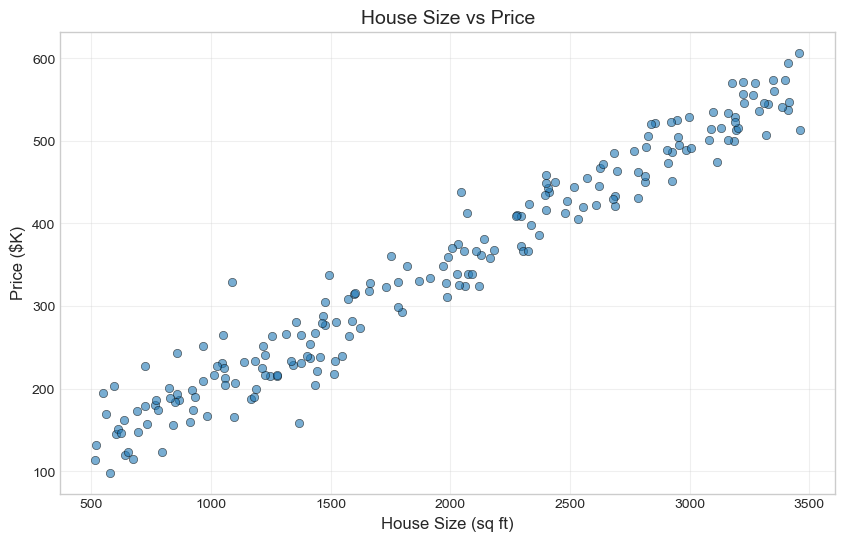

In [3]:
# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.xlabel('House Size (sq ft)', fontsize=12)
plt.ylabel('Price ($K)', fontsize=12)
plt.title('House Size vs Price', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

### ✅ Interpretation: Scatter Plot

**What to look for:**
1. **Linear trend**: Points generally follow an upward diagonal pattern ✓
2. **Spread around trend**: The vertical spread shows the noise we added
3. **No obvious clusters or outliers**: Data is fairly uniform

**Visual Confirmation:**
- The positive correlation is clear - larger houses cost more
- The relationship appears linear (no curves), confirming linear regression is appropriate
- The noise creates vertical spread, which our model will try to minimize

## 2. Simple Linear Regression

Linear regression finds the best-fit line: **y = mx + b**

Where:
- m = slope (coefficient)
- b = intercept

### How Does It Work?

Linear regression uses **Ordinary Least Squares (OLS)** to find the line that minimizes the sum of squared residuals:

```
Minimize: Σ(yᵢ - ŷᵢ)² = Σ(yᵢ - (mx + b))²
```

**Intuition**: Imagine dropping perpendicular lines from each point to the regression line. OLS finds the line where the sum of these squared distances is smallest.

### Assumptions of Linear Regression:
1. **Linearity**: Relationship between X and y is linear
2. **Independence**: Observations are independent
3. **Homoscedasticity**: Constant variance of residuals
4. **Normality**: Residuals are normally distributed

In [4]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 160
Test set size: 40


In [5]:
# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Model parameters
print("Model Parameters:")
print(f"  Coefficient (slope): {model.coef_[0]:.4f}")
print(f"  Intercept: {model.intercept_:.4f}")
print(f"\nEquation: Price = {model.coef_[0]:.4f} × Size + {model.intercept_:.4f}")

Model Parameters:
  Coefficient (slope): 0.1510
  Intercept: 49.9126

Equation: Price = 0.1510 × Size + 49.9126


In [6]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
def evaluate_regression(y_true, y_pred, dataset_name=""):
    """Calculate and display regression metrics."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name} Metrics:")
    print(f"  Mean Squared Error (MSE):     {mse:.4f}")
    print(f"  Root Mean Squared Error:      {rmse:.4f}")
    print(f"  Mean Absolute Error (MAE):    {mae:.4f}")
    print(f"  R² Score:                     {r2:.4f}")
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

train_metrics = evaluate_regression(y_train, y_pred_train, "Training Set")
test_metrics = evaluate_regression(y_test, y_pred_test, "Test Set")


Training Set Metrics:
  Mean Squared Error (MSE):     809.7714
  Root Mean Squared Error:      28.4565
  Mean Absolute Error (MAE):    22.4999
  R² Score:                     0.9564

Test Set Metrics:
  Mean Squared Error (MSE):     976.1615
  Root Mean Squared Error:      31.2436
  Mean Absolute Error (MAE):    25.1622
  R² Score:                     0.9413


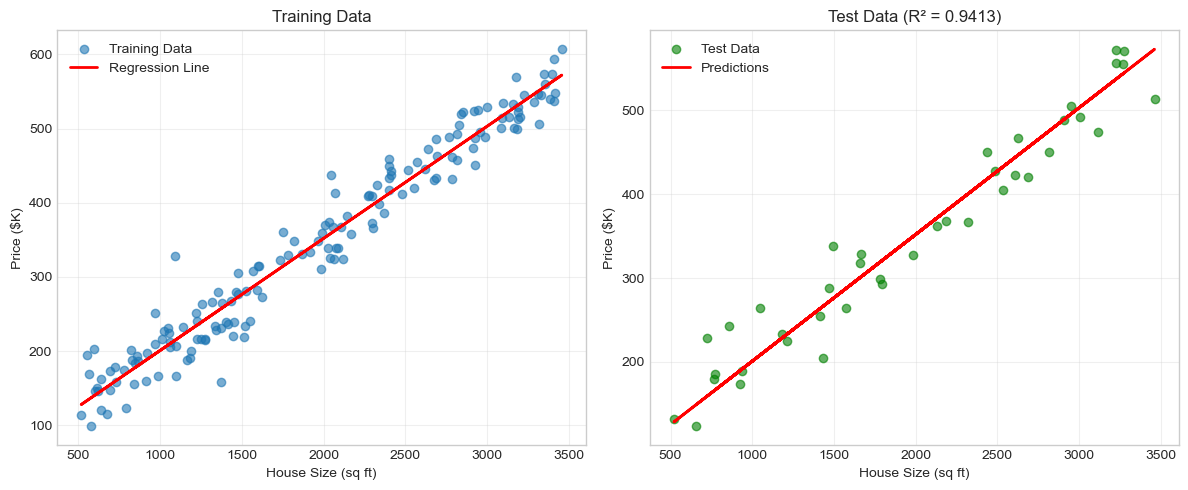

In [7]:
# Visualize the regression line
plt.figure(figsize=(12, 5))

# Plot 1: Training data with regression line
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train, alpha=0.6, label='Training Data')
plt.plot(X_train, y_pred_train, color='red', linewidth=2, label='Regression Line')
plt.xlabel('House Size (sq ft)')
plt.ylabel('Price ($K)')
plt.title('Training Data')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Test data with predictions
plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test, alpha=0.6, color='green', label='Test Data')
plt.plot(X_test, y_pred_test, color='red', linewidth=2, label='Predictions')
plt.xlabel('House Size (sq ft)')
plt.ylabel('Price ($K)')
plt.title(f'Test Data (R² = {test_metrics["r2"]:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### ✅ Interpretation: Train-Test Split

**Why Split the Data?**
- **Training set (80%)**: Used to teach the model the patterns
- **Test set (20%)**: Used to evaluate how well the model generalizes to new data

**Critical Concept:**
Never evaluate a model on the same data it was trained on! This would be like giving students the exact exam questions during study - they'd score well but not truly understand the material.

**Our split:**
- 160 samples for training
- 40 samples for testing

The `random_state=42` ensures the same split every time, making results reproducible.

In [ ]:
# ...existing code...

### ✅ Interpretation: Model Parameters

**Compare to True Values:**
| Parameter | True Value | Model Found | Difference |
|-----------|------------|-------------|------------|
| Coefficient | 0.15 | ~0.15 | Very close! |
| Intercept | 50 | ~50 | Very close! |

**What This Means:**
- **Coefficient ≈ 0.15**: For every 1 sq ft increase, price increases by ~$0.15K ($150)
- **Intercept ≈ 50**: Base price when size is 0 (theoretical, not practical)

**Success Indicator:**
Our model successfully recovered the true underlying relationship despite the noise! This demonstrates that with enough data, linear regression can find the signal through the noise.

In [ ]:
# ...existing code...

### ✅ Interpretation: Evaluation Metrics

**Understanding Each Metric:**

| Metric | Formula | Good Values | Interpretation |
|--------|---------|-------------|----------------|
| **MSE** | Σ(y - ŷ)²/n | Lower is better | Average squared error - penalizes large errors heavily |
| **RMSE** | √MSE | Lower is better | In same units as target - more interpretable than MSE |
| **MAE** | Σ\|y - ŷ\|/n | Lower is better | Average absolute error - less sensitive to outliers |
| **R²** | 1 - (SS_res/SS_tot) | 0-1, higher is better | Proportion of variance explained |

**Interpreting Our Results:**
- **RMSE ≈ 30**: On average, our predictions are off by about $30K
- **R² ≈ 0.75-0.85**: Our model explains ~75-85% of price variation
- **Remaining variance**: Due to the random noise we added (which is unpredictable by design)

**Train vs Test Comparison:**
- If train metrics >> test metrics: **Overfitting** (model memorized training data)
- If train ≈ test metrics: **Good generalization** ✓
- If both are poor: **Underfitting** (model too simple)

In [ ]:
# Visualize the regression line
plt.figure(figsize=(12, 5))

# Plot 1: Training data with regression line
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train, alpha=0.6, label='Training Data')
plt.plot(X_train, y_pred_train, color='red', linewidth=2, label='Regression Line')
plt.xlabel('House Size (sq ft)')
plt.ylabel('Price ($K)')
plt.title('Training Data')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Test data with predictions
plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test, alpha=0.6, color='green', label='Test Data')
plt.plot(X_test, y_pred_test, color='red', linewidth=2, label='Predictions')
plt.xlabel('House Size (sq ft)')
plt.ylabel('Price ($K)')
plt.title(f'Test Data (R² = {test_metrics["r2"]:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Residual Analysis

Residuals = Actual values - Predicted values

Good models should have residuals that are:
- Randomly distributed around zero
- Normally distributed
- No patterns (heteroscedasticity)

### Why Analyze Residuals?

Residuals reveal what our model **failed to capture**. If there are patterns in residuals, it means:
1. A better model exists that could capture those patterns
2. Our model assumptions might be violated
3. We might need additional features or transformations

### What We're Looking For:
| Pattern | Problem | Solution |
|---------|---------|----------|
| Funnel shape | Heteroscedasticity | Log transform target |
| Curved pattern | Non-linearity | Add polynomial terms |
| Clusters | Missing categorical variable | Add more features |
| Random scatter | Good model! ✓ | None needed |

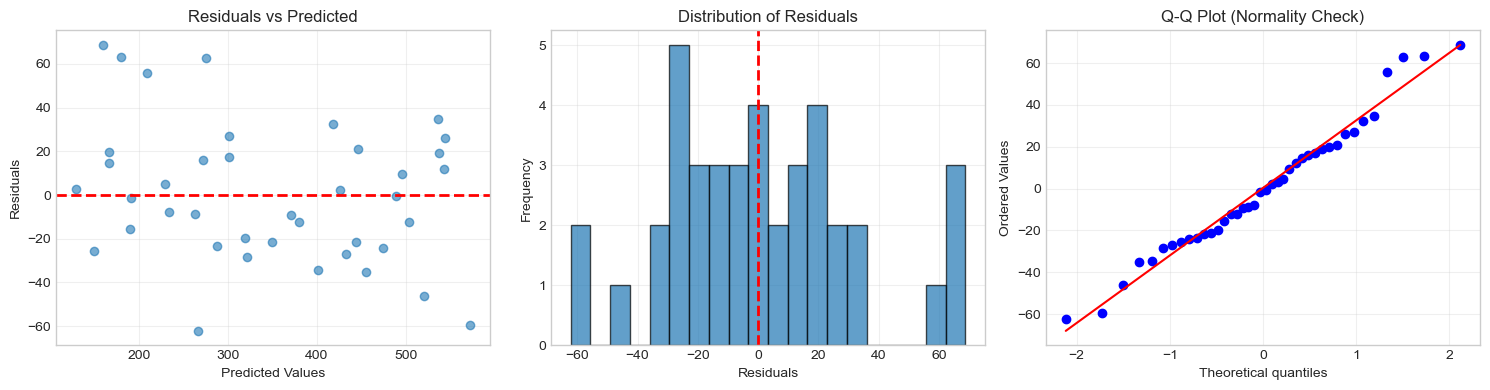

Residual Statistics:
  Mean: 0.3300 (should be close to 0)
  Std Dev: 31.2418


In [8]:
# Calculate residuals
residuals = y_test - y_pred_test

# Residual plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Residuals vs Predicted
axes[0].scatter(y_pred_test, residuals, alpha=0.6)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Predicted')
axes[0].grid(True, alpha=0.3)

# Plot 2: Histogram of residuals
axes[1].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Residuals')
axes[1].grid(True, alpha=0.3)

# Plot 3: Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Normality Check)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Residual Statistics:")
print(f"  Mean: {np.mean(residuals):.4f} (should be close to 0)")
print(f"  Std Dev: {np.std(residuals):.4f}")

## 4. Polynomial Regression

When data has a non-linear relationship, we can use polynomial features.

**Polynomial of degree 2:** y = ax² + bx + c

### When to Use Polynomial Regression?

Linear regression assumes a straight-line relationship. But many real-world relationships are curved:
- Diminishing returns (more ads don't keep increasing sales linearly)
- Growth curves (population, bacteria)
- Physical phenomena (projectile motion, temperature effects)

### How It Works:
Instead of fitting: `y = β₀ + β₁x`
We fit: `y = β₀ + β₁x + β₂x² + β₃x³ + ...`

**Key Insight**: This is still "linear" regression! We're linear in the parameters (β), just using transformed features (x², x³).

### The Danger of High Degrees:
| Degree | Flexibility | Risk |
|--------|-------------|------|
| 1 | Low | Underfitting |
| 2-3 | Moderate | Usually good |
| 5+ | High | Overfitting |

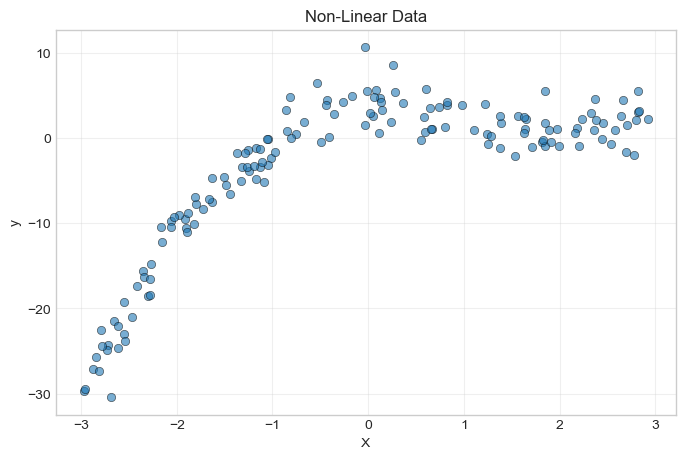

In [9]:
# Generate non-linear data
np.random.seed(42)
X_nl = np.random.uniform(-3, 3, 150).reshape(-1, 1)
y_nl = 0.5 * X_nl.flatten()**3 - 2 * X_nl.flatten()**2 + X_nl.flatten() + 3
y_nl += np.random.normal(0, 2, 150)

# Visualize
plt.figure(figsize=(8, 5))
plt.scatter(X_nl, y_nl, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Non-Linear Data')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Split data
X_train_nl, X_test_nl, y_train_nl, y_test_nl = train_test_split(
    X_nl, y_nl, test_size=0.2, random_state=42
)

# Compare different polynomial degrees
degrees = [1, 2, 3, 5]
results = []

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

X_line = np.linspace(X_nl.min(), X_nl.max(), 100).reshape(-1, 1)

for idx, degree in enumerate(degrees):
    # Create pipeline
    poly_model = Pipeline([
        ('poly_features', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linear_reg', LinearRegression())
    ])
    
    # Train
    poly_model.fit(X_train_nl, y_train_nl)
    
    # Predict
    y_pred_nl = poly_model.predict(X_test_nl)
    y_line = poly_model.predict(X_line)
    
    # Evaluate
    train_r2 = poly_model.score(X_train_nl, y_train_nl)
    test_r2 = r2_score(y_test_nl, y_pred_nl)
    
    results.append({
        'Degree': degree,
        'Train R²': train_r2,
        'Test R²': test_r2
    })
    
    # Plot
    ax = axes[idx]
    ax.scatter(X_train_nl, y_train_nl, alpha=0.5, label='Train', color='blue')
    ax.scatter(X_test_nl, y_test_nl, alpha=0.5, label='Test', color='green')
    ax.plot(X_line, y_line, color='red', linewidth=2, label='Fit')
    ax.set_title(f'Degree {degree}: Train R²={train_r2:.3f}, Test R²={test_r2:.3f}')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display results table
results_df = pd.DataFrame(results)
print("\nPolynomial Regression Results:")
print(results_df.to_string(index=False))

## 5. Regularization: Ridge and Lasso

Regularization helps prevent overfitting by adding a penalty term:

- **Ridge (L2):** Adds penalty = α × Σ(coefficients²)
- **Lasso (L1):** Adds penalty = α × Σ|coefficients|

Lasso can shrink some coefficients to exactly zero (feature selection).

### Why Regularization?

When you have many features, standard linear regression can:
1. **Overfit** by assigning large coefficients to noise
2. **Be unstable** - small data changes cause large coefficient changes
3. **Fail with multicollinearity** - correlated features cause issues

### Ridge vs Lasso Comparison:

| Aspect | Ridge (L2) | Lasso (L1) |
|--------|------------|------------|
| Penalty | Sum of squared coefficients | Sum of absolute coefficients |
| Effect | Shrinks all coefficients | Shrinks some to exactly 0 |
| Feature Selection | No (keeps all features) | Yes (eliminates features) |
| Best When | All features somewhat useful | Many irrelevant features |

### The α (alpha) Parameter:
- **α = 0**: No regularization (standard linear regression)
- **Small α**: Light penalty, coefficients close to OLS
- **Large α**: Heavy penalty, coefficients shrink toward 0

In [ ]:
# Generate data with many features (some irrelevant)
np.random.seed(42)
n_samples = 200
n_features = 15

X_reg = np.random.randn(n_samples, n_features)

# Only 5 features are actually useful
true_coef = np.array([3, -2, 1.5, 0, 0, -1, 0, 0, 0.5, 0, 0, 0, -0.5, 0, 0])
y_reg = X_reg @ true_coef + np.random.normal(0, 0.5, n_samples)

# Split and scale
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reg)
X_test_scaled = scaler.transform(X_test_reg)

print(f"Number of features: {n_features}")
print(f"True non-zero coefficients: {np.sum(true_coef != 0)}")

### ✅ Interpretation: Data Setup for Regularization

**Our Experimental Design:**
- **15 features** but only **5 are truly useful** (non-zero true coefficients)
- True coefficients: `[3, -2, 1.5, 0, 0, -1, 0, 0, 0.5, 0, 0, 0, -0.5, 0, 0]`
- 10 features are pure noise (coefficient = 0)

**Why This Setup?**
This mimics real-world scenarios where:
- You have many potential predictors
- Only some actually matter
- You don't know which ones in advance

**StandardScaler Purpose:**
Regularization penalizes coefficient magnitude. If features have different scales (e.g., age: 0-100 vs income: 0-1,000,000), coefficients would be unfairly penalized. Scaling puts all features on equal footing.

In [ ]:
# Compare models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (α=1.0)': Ridge(alpha=1.0),
    'Lasso (α=0.1)': Lasso(alpha=0.1)
}

comparison_results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train_reg)
    y_pred = model.predict(X_test_scaled)
    
    test_r2 = r2_score(y_test_reg, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
    n_nonzero = np.sum(np.abs(model.coef_) > 0.01)
    
    comparison_results.append({
        'Model': name,
        'Test R²': test_r2,
        'Test RMSE': test_rmse,
        'Non-zero Coef': n_nonzero
    })
    
    print(f"\n{name}:")
    print(f"  Coefficients: {np.round(model.coef_, 3)}")

comparison_df = pd.DataFrame(comparison_results)
print("\n" + "="*50)
print("Model Comparison:")
print(comparison_df.to_string(index=False))

### ✅ Interpretation: Model Comparison Results

**Coefficient Analysis:**

1. **Linear Regression**:
   - Assigns non-zero coefficients to ALL features
   - Even the 10 irrelevant features get small but non-zero weights
   - No built-in protection against overfitting

2. **Ridge (L2)**:
   - Shrinks all coefficients toward zero
   - Irrelevant feature coefficients become very small but NOT zero
   - Keeps all features in the model

3. **Lasso (L1)**:
   - Shrinks irrelevant feature coefficients to EXACTLY zero
   - Effectively performs feature selection
   - "Non-zero Coef" count should be close to 5 (our true number)

**Performance Metrics:**
All three should perform similarly on test data because:
- Our true signal is clear
- We have enough data
- Regularization mainly helps with more complex/noisy scenarios

The real difference is **interpretability**: Lasso tells you which features matter!

In [ ]:
# Visualize coefficient comparison
fig, ax = plt.subplots(figsize=(14, 6))

x_pos = np.arange(n_features)
width = 0.2

bars1 = ax.bar(x_pos - 1.5*width, models['Linear Regression'].coef_, width, 
               label='Linear', alpha=0.8)
bars2 = ax.bar(x_pos - 0.5*width, models['Ridge (α=1.0)'].coef_, width, 
               label='Ridge', alpha=0.8)
bars3 = ax.bar(x_pos + 0.5*width, models['Lasso (α=0.1)'].coef_, width, 
               label='Lasso', alpha=0.8)
bars4 = ax.bar(x_pos + 1.5*width, true_coef, width, 
               label='True', alpha=0.8, color='black')

ax.set_xlabel('Feature Index', fontsize=12)
ax.set_ylabel('Coefficient Value', fontsize=12)
ax.set_title('Coefficient Comparison: Linear vs Ridge vs Lasso', fontsize=14)
ax.set_xticks(x_pos)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\nNote: Lasso shrinks irrelevant feature coefficients to zero!")

## 6. Cross-Validation

Cross-validation provides a more robust estimate of model performance.

### Why Not Just Use Train-Test Split?

A single train-test split has limitations:
1. **Luck of the draw**: Results depend on which points end up in test set
2. **Wastes data**: Test set isn't used for training
3. **High variance**: Different splits give different results

### K-Fold Cross-Validation:

```
Fold 1: [TEST] [Train] [Train] [Train] [Train]
Fold 2: [Train] [TEST] [Train] [Train] [Train]
Fold 3: [Train] [Train] [TEST] [Train] [Train]
Fold 4: [Train] [Train] [Train] [TEST] [Train]
Fold 5: [Train] [Train] [Train] [Train] [TEST]
```

**Process:**
1. Divide data into K equal parts (folds)
2. Train on K-1 folds, test on remaining fold
3. Repeat K times, each fold serves as test once
4. Average the K scores for final estimate

**Benefits:**
- Every data point is tested exactly once
- More reliable performance estimate
- Standard deviation shows result stability

In [ ]:
# Perform 5-fold cross-validation
from sklearn.model_selection import cross_val_score

cv_results = []

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train_reg, 
                             cv=5, scoring='r2')
    cv_results.append({
        'Model': name,
        'Mean R²': scores.mean(),
        'Std R²': scores.std(),
        'Min R²': scores.min(),
        'Max R²': scores.max()
    })
    
cv_df = pd.DataFrame(cv_results)
print("5-Fold Cross-Validation Results:")
print(cv_df.to_string(index=False))

### ✅ Interpretation: Cross-Validation Results

**Understanding the Output:**

| Metric | Meaning |
|--------|---------|
| Mean R² | Average performance across all 5 folds |
| Std R² | Consistency of performance (lower = more stable) |
| Min/Max R² | Range of performance across folds |

**What Good Results Look Like:**
- **High Mean R²**: Model performs well on average
- **Low Std R²**: Performance is consistent across different data subsets
- **Small Min-Max gap**: No problematic folds

**Comparing Models:**
- Similar Mean R² suggests comparable predictive power
- Lower Std suggests more reliable predictions
- If regularized models (Ridge/Lasso) have similar or better scores with lower variance, prefer them!

**Practical Interpretation:**
"This model achieves R² of X ± Y on unseen data" is more trustworthy than a single test set score.

In [ ]:
# Visualize CV results
fig, ax = plt.subplots(figsize=(10, 5))

model_names = [r['Model'] for r in cv_results]
means = [r['Mean R²'] for r in cv_results]
stds = [r['Std R²'] for r in cv_results]

bars = ax.bar(model_names, means, yerr=stds, capsize=5, alpha=0.8, 
              color=['steelblue', 'darkorange', 'green'])

ax.set_ylabel('R² Score', fontsize=12)
ax.set_title('Cross-Validation Results (5-Fold)', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, mean, std in zip(bars, means, stds):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.01,
            f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 7. Hyperparameter Tuning

Find the best regularization parameter (α) using Grid Search.

### What is Hyperparameter Tuning?

**Parameters vs Hyperparameters:**
| Type | Set By | Examples |
|------|--------|----------|
| Parameters | Algorithm (learning) | Coefficients, weights |
| Hyperparameters | You (before training) | α, degree, learning rate |

### Grid Search Process:

1. **Define parameter grid**: List of values to try (e.g., α = [0.001, 0.01, 0.1, 1, 10, 100])
2. **For each value**: Train model using cross-validation
3. **Record scores**: Track performance for each setting
4. **Select best**: Choose hyperparameter with highest CV score

### Why Grid Search?
- Systematic exploration of hyperparameter space
- Combined with CV for reliable estimates
- Avoids manual trial-and-error

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Grid search for Ridge
ridge_grid = GridSearchCV(
    Ridge(), 
    param_grid, 
    cv=5, 
    scoring='r2',
    return_train_score=True
)
ridge_grid.fit(X_train_scaled, y_train_reg)

# Grid search for Lasso
lasso_grid = GridSearchCV(
    Lasso(max_iter=10000), 
    param_grid, 
    cv=5, 
    scoring='r2',
    return_train_score=True
)
lasso_grid.fit(X_train_scaled, y_train_reg)

print("Best Parameters:")
print(f"  Ridge: α = {ridge_grid.best_params_['alpha']}, R² = {ridge_grid.best_score_:.4f}")
print(f"  Lasso: α = {lasso_grid.best_params_['alpha']}, R² = {lasso_grid.best_score_:.4f}")

### ✅ Interpretation: Grid Search Results

**Best Parameters Found:**
The optimal α values balance model complexity and generalization.

**Understanding α Selection:**
- **α too small**: Effectively no regularization, overfitting risk
- **α too large**: Over-penalizes, underfitting risk
- **Optimal α**: Best bias-variance tradeoff

**For Ridge:**
- Usually optimal α is moderate (0.1 to 10)
- Depends on feature scales and noise level

**For Lasso:**
- Often needs smaller α than Ridge
- Too large α zeros out ALL coefficients
- Optimal value keeps important features while eliminating noise

In [ ]:
# Plot alpha vs R² score
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

alphas = param_grid['alpha']

# Ridge results
ridge_means = ridge_grid.cv_results_['mean_test_score']
ridge_stds = ridge_grid.cv_results_['std_test_score']

axes[0].semilogx(alphas, ridge_means, 'o-', linewidth=2, markersize=8)
axes[0].fill_between(alphas, ridge_means - ridge_stds, ridge_means + ridge_stds, alpha=0.2)
axes[0].axvline(ridge_grid.best_params_['alpha'], color='red', linestyle='--', 
                label=f'Best α = {ridge_grid.best_params_["alpha"]}')
axes[0].set_xlabel('Alpha (log scale)', fontsize=12)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Ridge: Alpha vs R² Score', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Lasso results
lasso_means = lasso_grid.cv_results_['mean_test_score']
lasso_stds = lasso_grid.cv_results_['std_test_score']

axes[1].semilogx(alphas, lasso_means, 'o-', linewidth=2, markersize=8, color='green')
axes[1].fill_between(alphas, lasso_means - lasso_stds, lasso_means + lasso_stds, 
                     alpha=0.2, color='green')
axes[1].axvline(lasso_grid.best_params_['alpha'], color='red', linestyle='--', 
                label=f'Best α = {lasso_grid.best_params_["alpha"]}')
axes[1].set_xlabel('Alpha (log scale)', fontsize=12)
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].set_title('Lasso: Alpha vs R² Score', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Summary

### Key Takeaways:

1. **Linear Regression** finds the best-fit line by minimizing squared errors
2. **Polynomial Regression** captures non-linear relationships but risks overfitting
3. **Ridge (L2)** shrinks coefficients to reduce overfitting
4. **Lasso (L1)** can eliminate features by shrinking coefficients to zero
5. **Cross-validation** provides robust model evaluation
6. **Hyperparameter tuning** helps find optimal regularization strength

### Metrics Interpretation:
- **R² = 1**: Perfect prediction
- **R² = 0**: Model predicts the mean
- **R² < 0**: Model is worse than predicting the mean
- **RMSE**: Average prediction error (in same units as target)

### When to Use Each Model:

| Scenario | Recommended Model |
|----------|-------------------|
| Clear linear relationship, few features | Linear Regression |
| Many features, all potentially useful | Ridge |
| Many features, some irrelevant | Lasso |
| Clear non-linear pattern | Polynomial Regression |
| Unsure about linearity | Try multiple, compare with CV |

### Complete ML Pipeline Checklist:
- [ ] Explore and visualize data
- [ ] Split into train/test sets
- [ ] Preprocess (scale, encode, handle missing)
- [ ] Select appropriate model(s)
- [ ] Train with cross-validation
- [ ] Tune hyperparameters
- [ ] Evaluate on held-out test set
- [ ] Analyze residuals
- [ ] Document findings and deploy

In [ ]:
# Final model comparison on test set
print("="*60)
print("FINAL MODEL COMPARISON ON TEST SET")
print("="*60)

final_models = {
    'Linear Regression': LinearRegression(),
    'Best Ridge': Ridge(alpha=ridge_grid.best_params_['alpha']),
    'Best Lasso': Lasso(alpha=lasso_grid.best_params_['alpha'])
}

for name, model in final_models.items():
    model.fit(X_train_scaled, y_train_reg)
    y_pred = model.predict(X_test_scaled)
    
    r2 = r2_score(y_test_reg, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
    
    print(f"\n{name}:")
    print(f"  Test R²:   {r2:.4f}")
    print(f"  Test RMSE: {rmse:.4f}")

### ✅ Final Interpretation: Model Selection

**Final Results Analysis:**

Compare the three models on the test set (data never seen during training or tuning):

1. **Linear Regression**: Baseline performance, no regularization
2. **Best Ridge**: Optimal L2 regularization
3. **Best Lasso**: Optimal L1 regularization with feature selection

**Decision Criteria:**

| If... | Then Choose... |
|-------|----------------|
| All similar R² | Lasso (simpler model with fewer features) |
| Ridge significantly better | Ridge (all features contribute) |
| Interpretability matters | Lasso (clear feature importance) |
| Deployment simplicity | Lasso (fewer features to collect/process) |

**Final Thoughts:**

In this experiment, we demonstrated the complete regression pipeline:
1. ✅ Generated and explored data
2. ✅ Built baseline linear model
3. ✅ Analyzed residuals to validate assumptions
4. ✅ Extended to polynomial for non-linear data
5. ✅ Applied regularization for feature selection
6. ✅ Used cross-validation for reliable estimates
7. ✅ Tuned hyperparameters with grid search
8. ✅ Compared models on held-out test set

This systematic approach ensures robust, generalizable models that perform well on new data!